<a href="https://colab.research.google.com/github/PepiMartin28/FootballLogos-VAE/blob/develop/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook utilizada para testear el modelo y probar la interpolación

In [ ]:
import os
import pandas as pd
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import Dataset
import torch.distributions
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt;

In [ ]:
!gdown https://drive.google.com/uc?id=1yXdPhk-OZ-lhGMYbsP_FHc-22Xhsu5Ux
!gdown https://drive.google.com/uc?id=1x-CtdUFfrhAqsHAILxdqkAj9fUG-xTgQ
!unzip logos.zip

In [ ]:
class LogoDataset(Dataset):
  def __init__(self, annotations_file):
    self.archivo = pd.read_csv(annotations_file)
    self.transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
        ])

  def __len__(self):
    return len(self.archivo["id"])

  def __getitem__(self, idx):
    label = self.archivo.loc[idx,"name"]
    img_path = self.archivo.loc[idx,"img_dir"]
    image = Image.open(img_path).convert("RGBA")
    image = self.transform(image)
    return image, label

dataset = LogoDataset("/content/logos/logos.csv")

dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=True,)

In [ ]:
n_G = 32

class AUG_block(nn.Module):
    def __init__(self, out_channels, in_channels=4, kernel_size=5, strides=2,
                 padding=1, **kwargs):
        super(AUG_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

class DEC_block(nn.Module):
    def __init__(self, out_channels, in_channels=4, kernel_size=5, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(DEC_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

class Variational_Encoder(nn.Module):
    def __init__(self, latent_dims, n_channels=4):
        super(Variational_Encoder, self).__init__()
        self.conv_seq = nn.Sequential(
            DEC_block(in_channels=n_channels, out_channels=n_G),
            DEC_block(in_channels=n_G, out_channels=n_G*2),
            DEC_block(in_channels=n_G*2, out_channels=n_G*4),
            DEC_block(in_channels=n_G*4, out_channels=n_G*8),
            DEC_block(in_channels=n_G*8, out_channels=n_G*16),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(latent_dims)
        )
        self.linear3 = nn.LazyLinear(latent_dims)
        self.linear4 = nn.LazyLinear(latent_dims)

    def forward(self, x):
        z = self.conv_seq(x)
        media = self.linear3(z)
        log_var = F.relu(self.linear4(z))
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        latente = eps.mul(std).add_(media)
        return (latente, media, log_var)


class Decoder(nn.Module):
    def __init__(self, latent_dims, n_channels=4):
        super(Decoder, self).__init__()
        self.seq = nn.Sequential(
            AUG_block(in_channels=latent_dims, out_channels=n_G*16, strides=1, padding=0), #[5, 5]
            AUG_block(in_channels=n_G*16, out_channels=n_G*8), #[11, 11]
            AUG_block(in_channels=n_G*8, out_channels=n_G*4), #[23, 23]
            AUG_block(in_channels=n_G*4, out_channels=n_G*2), #[47, 47]
            AUG_block(in_channels=n_G*2, out_channels=n_G, strides=3, padding = 9), #[125, 125]
            nn.ConvTranspose2d(in_channels=n_G, out_channels=4, kernel_size=2, stride=2, padding=25, bias=False), #[200, 200]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.seq(z)

class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dims, n_channels=4):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Variational_Encoder(latent_dims, n_channels)
        self.decoder = Decoder(latent_dims, n_channels)

    def forward(self, x):
        z, media, log_var = self.encoder(x)
        z = z.unsqueeze(2).unsqueeze(3)
        return self.decoder(z), media, log_var

In [ ]:
latent_dims = 700
vae = Variational_Autoencoder(latent_dims)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
vae.load_state_dict(torch.load('/content/vae-weights-700DV5.params', map_location="cpu"))

<All keys matched successfully>

In [ ]:
vae.eval()

In [ ]:
df = pd.read_csv("/content/logos/logos.csv")

In [ ]:
transformaciones=transforms.Compose([transforms.Resize((200, 200)),transforms.ToTensor()])

In [ ]:
img1 = df[(df['name'] == "Barcelona") & (df['league'] == "espana")]["img_dir"]
image1 = transformaciones(Image.open(img1.iloc[0]).convert("RGBA"))
img2 = df[df['name'] == "Real Madrid"]["img_dir"]
image2 = transformaciones(Image.open(img2.iloc[0]).convert("RGBA"))

In [ ]:
img1 = df.sample(1)["img_dir"]
image1 = transformaciones(Image.open(img1.iloc[0]).convert("RGBA"))
img2 = df.sample(1)["img_dir"]
image2 = transformaciones(Image.open(img2.iloc[0]).convert("RGBA"))

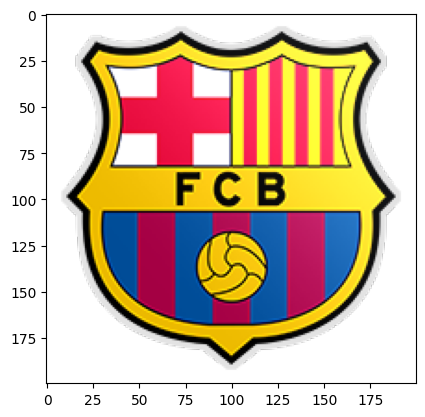

In [ ]:
imagen_tensor = image1.permute(1, 2, 0)

imagen_np = imagen_tensor.cpu().numpy()

plt.figure()
plt.imshow(imagen_np)
plt.show()

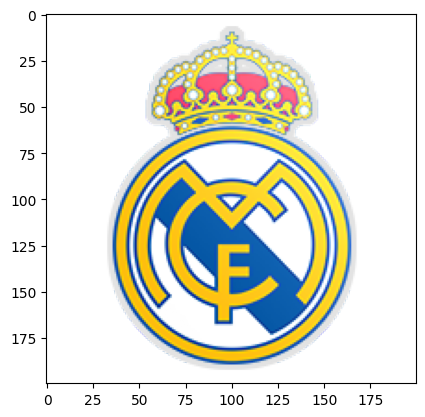

In [ ]:
imagen_tensor = image2.permute(1, 2, 0)

imagen_np = imagen_tensor.cpu().numpy()

plt.figure()
plt.imshow(imagen_np)
plt.show()

In [ ]:
def get_interp(v1, v2, n):
  if not v1.shape == v2.shape:
    raise Exception('Different vector size')

  return np.array([np.linspace(v1[i], v2[i], n+2) for i in range(v1.shape[0])]).T

In [ ]:
img1_compressed,_,_ = vae.encoder(image1.unsqueeze(0))
img2_compressed,_,_ = vae.encoder(image2.unsqueeze(0))

In [ ]:
interp = get_interp(img1_compressed.detach(), img2_compressed.detach(), 10)

interp = torch.from_numpy(interp)

interp = interp.permute(1,0,2).unsqueeze(3)

results = vae.decoder(interp)

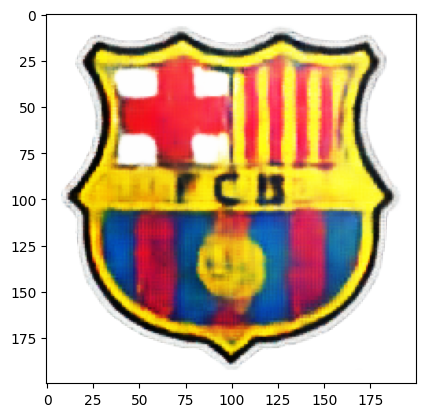

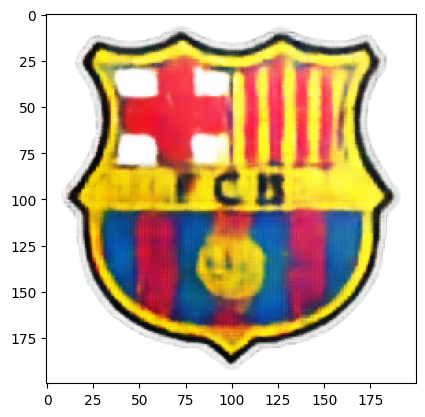

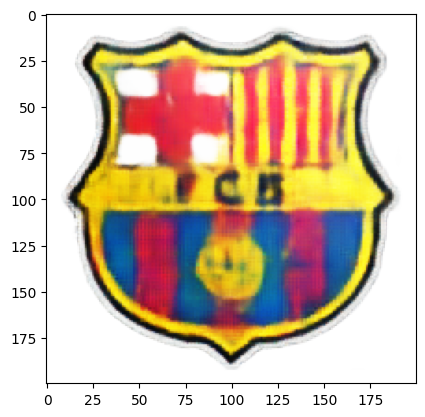

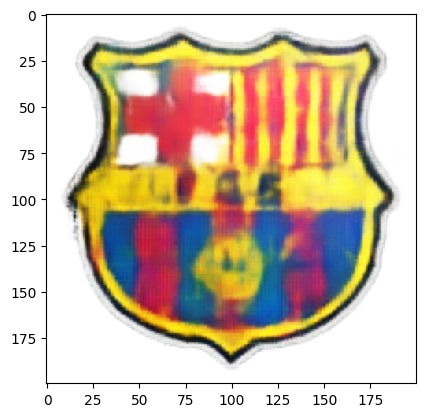

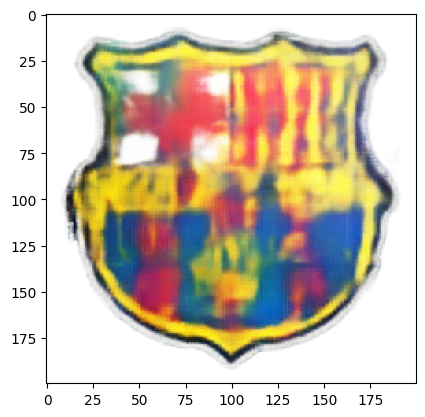

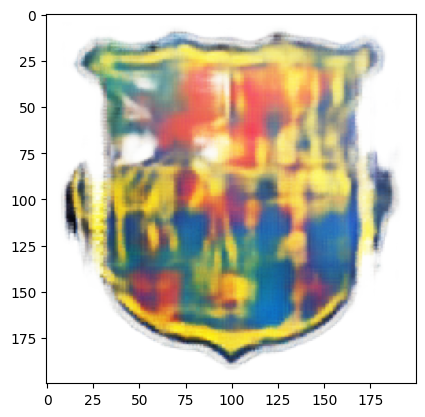

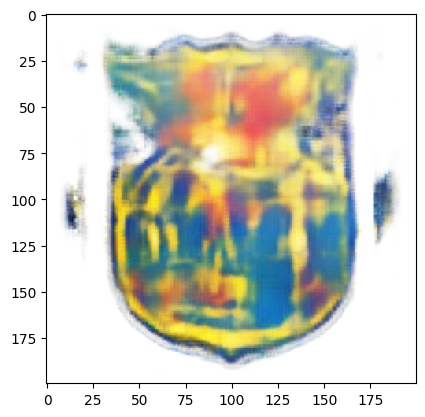

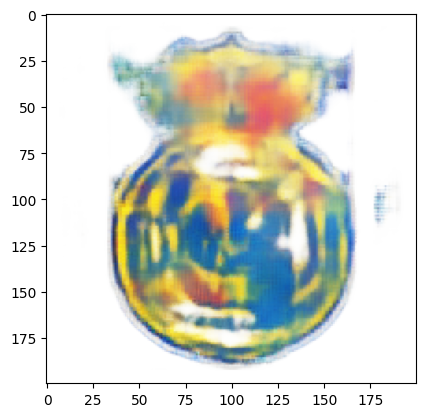

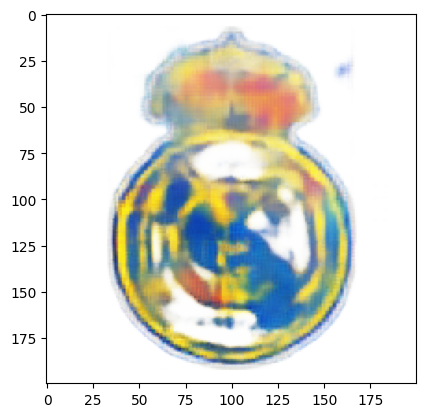

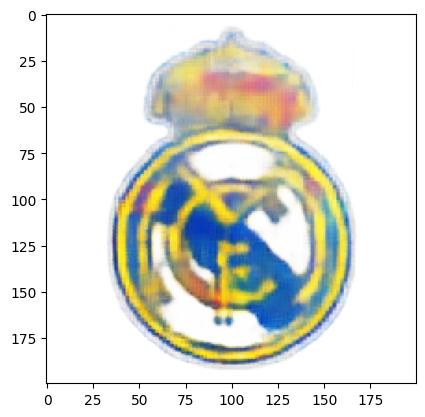

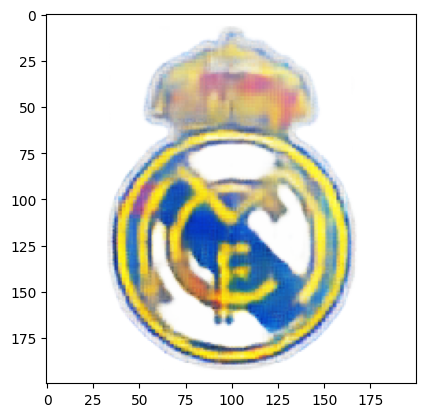

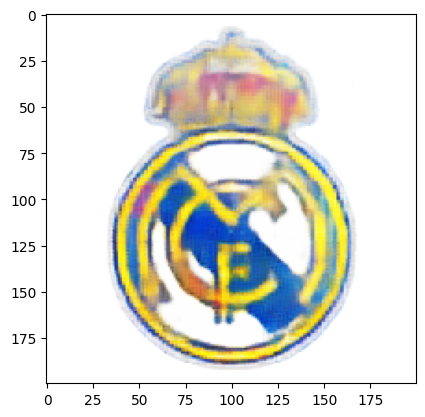

In [ ]:
for imagen in results:
  imagen_tensor = imagen.detach().squeeze(0).permute(1, 2, 0)

  imagen_np = imagen_tensor.cpu().numpy()

  plt.figure()
  plt.imshow(imagen_np)
  plt.show()